# 📡 Характеристика канала между RFID считывателем и меткой
В ноутбуке представлены результаты моделирования канала для случая, когда RFID считыватель закреплён на движущимся равномерно и прямолинейно БПЛА, а метки неподвижно лежат на земеле на таком расстоянии, что между ними никогда не возникает коллизий.
В ноутбуке приведены результаты для нескольких сценариев:
1) БПЛА и метка неподвижны друг относительно друга (дрон завис в воздухе)
2) Дрон движется, метка принимает только прямой луч (дрон над полем без препятствий)
3) Дрон движется, на метку попадает прямой и отражённый лучи (дрон летит вдоль стены, от которой происходит отражение)

In [1]:
from matplotlib import patches
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
import numpy as np

from pysim.models.rfid import channel
from utility.graphs_style import (
    get_color, setup_matplotlib,
)
import pysim.models.rfid.epcstd as epc

In [2]:
%matplotlib inline
setup_matplotlib()

## 🔧 Параметры моделирования
Для работы модели требуется определить положение метки и считывателя в трёхмерном пространстве с помощью декартовых координат.
* Симуляция проходит в трёхмерном пространстве. Это значение хранит константа `DIMENSION_OF_SPACE`. Соответственно, все координаты, вектора скорости и направления антенн определяются как трёхмерные массивы координат типа `np.array`;
* Точка `(0;0;0)` находится у основания стены (TODO: картинка);
* Ось абцисс `(OX)` направлена перпендикулярно движению БПЛА со считывателем;
* Ось ординат `(OY)` направлена параллельно движению БПЛА;
* Ось аппликат `(OZ)` направлена вдоль стены вверх;
* Стена (если есть) находится в плоскости `YOZ`;

Требования:
1) Положение считывателя и метки указывается как `np.array((x, y, z))`, где x, y, z - координаты в метрах в начале моделирования;

### 🌍 Параметры окружающей среды

In [3]:
FREQUENCY = 860_000_000              # Гц
SPEED_OF_LIGHT = 299_792_458         # М/с
WAVELEN = SPEED_OF_LIGHT / FREQUENCY
THERMAL_NOISE = -114.0               # dBm
DIMENSION_OF_SPACE = 3
MINIMUM_DISTANCE = -15  # Минимальное расстояние по земле, на котором будет рассматриваться система, м
MAXIMUM_DISTANCE = 15   # Максимальное расстояние по земле, на котором будет рассматриваться система, м
GRID_STEP = 200         # Шаг, с которым строятся графики

# Поляризация--------------------------------
VERTICAL_POLARIZATION = 0.0
HORIZONTAL_POLARIZATION = 1.0
CIRCULAR_POLARIZATION = 0.5

# Характеристики поверхности отражения-------
PERMITTIVITY = 15
CONDUCTIVITY = 0.03

REFLECTION = channel.reflection
RADIATION_PATTERN = channel.rp_dipole

### 📶 Параметры RFID считывателя

In [4]:
DEFAULT_SPEED = 10             # Метров в секунду
DEFAULT_ORIENTATION = 'front'  # front или back

READER_POS = np.array((5.0, 0, 5.0))               # Высота 5 метров
READER_ANTENNA_DIRECTION = np.array((0, 0, -1.0))  # Направление антенны считывателя (вниз)
READER_POLARIZATION = CIRCULAR_POLARIZATION        # Поляризация антенны
READER_GAIN = 8            # Усиление антенны
READER_CABLE_LOSS = -2.0   # dBm
READER_NOISE = -80.0       # dBm
READER_TX_POWER = 31.5     # dBm
READER_SENSITIVITY = -80.0 # dBm

# Протокол-----------------------------
DR = epc.DivideRatio.DR_8
RTCAL_MUL = 2.75
TRCAL_MUL = 1.95 # TODO: унифицировать везде множители

### 🏷️ Параметры RFID метки

In [5]:
TAG_POS = np.array((5.0, 0, 0))                # Метка на земле
TAG_ANTENNA_DIRECTION = np.array((0, 0, 1.0))  # Направление антенны метки (вверх)
TAG_POLARIZATION = HORIZONTAL_POLARIZATION     # Поляризация антенны
TAG_SENSITIVITY = -18.0       # dBm
TAG_GAIN = 2.0                # Усиление антенны
TAG_BACKSCATTER_LOSS = -10.0  # dBm

### 🎨 Настройки графиков

In [6]:
FIGSIZE = (8, 5)
LINEWIDTH = 2
MARKERSIZE = 8
MARKEVERY = 20
LEGEND_FONTSIZE = 14

PARAMS_1_BEAM = {'color': get_color(0), 'linewidth': 2, 'linestyle': '-.',
           'marker': 'X', 'markersize': 8, 'markevery': 20,
           'label': 'Канал без отражений'}
PARAMS_VERT = {'color': get_color(0.2), 'linewidth': LINEWIDTH,
           'linestyle': '-', 'marker': 'v', 'markersize': MARKERSIZE,
           'markevery': MARKEVERY, 'label': 'Вертикальная поляризация'}
PARAMS_CIRC = {'color': get_color(0.5), 'linewidth': LINEWIDTH,
               'linestyle': '--', 'marker': 'o', 'markersize': MARKERSIZE,
               'markevery': MARKEVERY, 'label': 'Круговая поляризация'}
PARAMS_HOR = {'color': get_color(0.8), 'linewidth': LINEWIDTH,
              'linestyle': '-', 'marker': '^', 'markersize': MARKERSIZE,
              'markevery': MARKEVERY, 'label': 'Горизонтальная поляризация'}
PARAMS_HOR_SPEED = {'color': get_color(0), 'linewidth': LINEWIDTH,
              'linestyle': ':', 'marker': '^', 'markersize': MARKERSIZE,
              'markevery': MARKEVERY,
              'label': 'Горизонтальная поляризация\nс эффектом Доплера'}

## 📈 Коэффициент отражения
* Играет роль при двухлучевом распространения сигнала, так как в однолучевом случае отсутствует отражённая компонента;
* Зависит от диэлектрической проницаемости `PERMITTIVITY` и проводимости `CONDUCTIVITY` поверхности, от которой отражается луч радиосигнала, а также от его угла падения.

In [7]:
def get_reflection(
    incidence_angle: float,
    pol: float,
    permittivity: float = PERMITTIVITY,
    conductivity: float = CONDUCTIVITY, 
    wavelen: float = WAVELEN
) -> float:
    """
    Рассчитать коэффициент отражения радиосигнала от поверхности.

    Args:
        incidence_angle: угол падения сигнала (в радианах)
        pol: поляризация сигнала (принимает значения: 0, 0.5, 1)
        permittivity: диэлектрическая проницаемость поверхности
        conductivity: проводимость поверхности
        wavelen: длина волны сигнала

    Returns:
        абсолютное значение коэффициента отражения
    """
    return abs(
        channel.reflection(
            cosine=np.cos(incidence_angle),
            polarization=pol,
            permittivity=permittivity,
            conductivity=conductivity,
            wavelen=wavelen
        )
    )

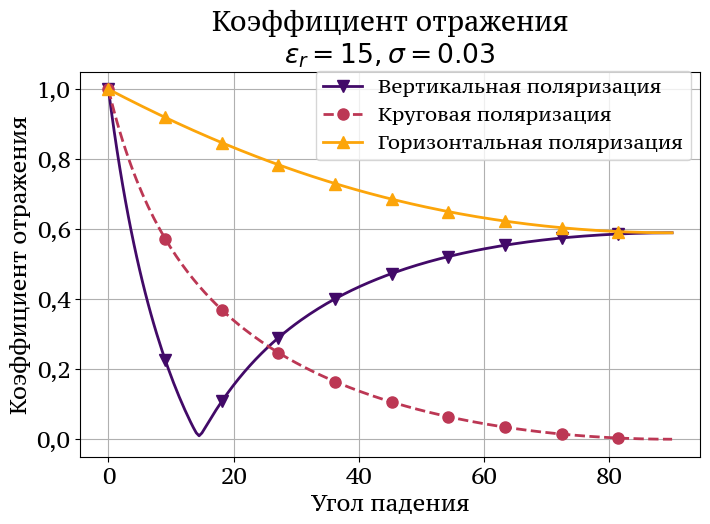

In [8]:
def plot_reflection(image_name: str = '', save_fig: bool = False) -> None:
    """
    Нарисовать графики коэффициента отражения в зависимости от 
    угла падения сигнала для разных типов поляризаций антенны считывателя.
    
    Args:
        image_name (str): имя файла без расширения
    """
    # Получение результатов
    oa_axis = np.linspace(0, 90, GRID_STEP)  # Угол падения, градусы
    reflection_vert = [
        get_reflection(channel.deg2rad(incidence_angle), VERTICAL_POLARIZATION)
        for incidence_angle in oa_axis
    ]
    reflection_circ = [
        get_reflection(channel.deg2rad(incidence_angle), CIRCULAR_POLARIZATION)
        for incidence_angle in oa_axis
    ]
    reflection_hor = [
        get_reflection(channel.deg2rad(incidence_angle),
                       HORIZONTAL_POLARIZATION)
        for incidence_angle in oa_axis
    ]

    # Оформление графиков
    fig, ax = plt.subplots(figsize=FIGSIZE, nrows=1, ncols=1)
    ax.set_title('Коэффициент отражения\n' + 
                  fr'$\epsilon_r = {PERMITTIVITY}, \sigma = {CONDUCTIVITY}$')
    ax.set_xlabel('Угол падения')
    ax.set_ylabel('Коэффициент отражения')
    ax.plot(oa_axis, reflection_vert, **PARAMS_VERT)
    ax.plot(oa_axis, reflection_circ, **PARAMS_CIRC)
    ax.plot(oa_axis, reflection_hor, **PARAMS_HOR)
    ax.grid()
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9),
               fontsize=LEGEND_FONTSIZE)


# Вызов функции
plot_reflection(image_name='', save_fig=False)

## 📉 Расчет затуханий

Канал считыватель - метка.

Для расчета затуханий используется функция `pathloss_model` из модуля `channel.py`, но здесь описаны более удобные обертки.

In [9]:
def get_free_space_pathloss(y: float, v: float = 0, t: float = 0) -> float:
    """
    Расчёт затухания в канале без отражений (прямой путь).

    Args:
        y: координата считывателя вдоль оси OY (в метрах)
        v: скорость движения считывателя вдоль оси OY (м/с)
        t: время с момента начала передачи (с)

    Returns:
        затухание в дБ
    """
    return channel.pathloss_model(
        time=t,
        wavelen=WAVELEN, 
        # Параметры считывателя: ---------------------------
        tx_pos=np.array((READER_POS[0], y, READER_POS[2])),
        tx_antenna_dir=READER_ANTENNA_DIRECTION,
        tx_rp=RADIATION_PATTERN,
        tx_velocity=np.array((0, v, 0)),
        # Параметры метки: ---------------------------------
        rx_pos=TAG_POS,
        rx_antenna_dir=TAG_ANTENNA_DIRECTION,
        rx_rp=RADIATION_PATTERN,
        rx_velocity=np.zeros(DIMENSION_OF_SPACE),
        # ---------------------------------------------------
        log=True   
    )

In [10]:
def get_pathloss(
    y: float, pol: float, v: float = DEFAULT_SPEED, t: float = 0.1
) -> float:
    """
    Расчёт затухания в двухлучевом канале (с отражением от стены).
    Значения затухания будут разными для каналов от считывателя к метке
    и обратно только из-за поляризации, так как от нее зависит
    коэффициент отражения. Все остальное - симметрично.

    Args:
        y: координата считывателя вдоль оси OY
        pol: поляризация сигнала (принимает значения: 0, 0.5, 1)
        v: скорость считывателя вдоль оси OY
        t: время с момента начала передачи

    Returns:
        затухание в dB
    """
    return channel.pathloss_model(
        time=t,
        wavelen=WAVELEN, 
        # Параметры считывателя: ---------------------------
        tx_pos=np.array((READER_POS[0], y, READER_POS[2])),
        tx_antenna_dir=READER_ANTENNA_DIRECTION,
        tx_rp=RADIATION_PATTERN,
        tx_velocity=np.array((0, v, 0)),
        # Параметры метки: ---------------------------------
        rx_pos=TAG_POS,
        rx_antenna_dir=TAG_ANTENNA_DIRECTION,
        rx_rp=RADIATION_PATTERN,
        rx_velocity=np.zeros(DIMENSION_OF_SPACE),
        # Параметры отражения: -----------------------------
        tx_polarization=pol,
        ground_reflection=REFLECTION, 
        conductivity=CONDUCTIVITY, 
        permittivity=PERMITTIVITY,
        # ---------------------------------------------------
        log=True
    )

Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!
Однолучевой случай!


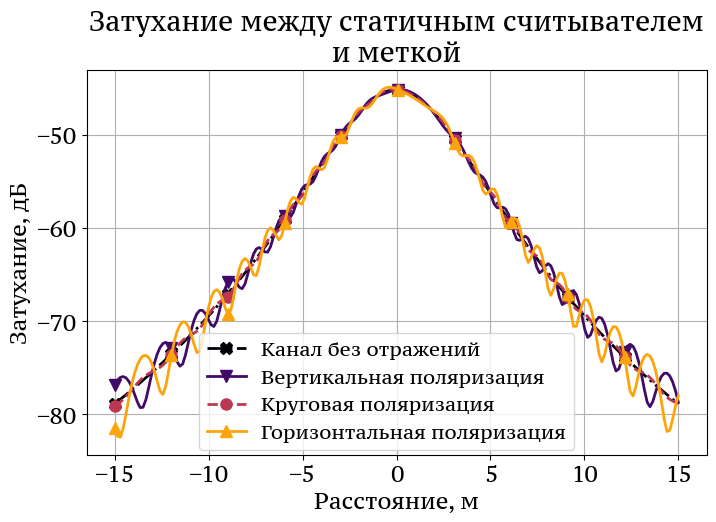

In [11]:
def plot_pathlosses(image_name: str = '', save_fig: bool = False) -> None:
    """
    Построение графиков затухания сигнала для разных поляризаций.
    Под ox_axis понимается ось абсцисс создаваемого графика.

    Args:
        image_name: имя файла для сохранения (без расширения)
        save_fig: сохранить ли изображение
    """
    # Получение результатов
    ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)  # Расстояние, м    
    free_space_pathloss = [get_free_space_pathloss(x, 0, 0) for x in ox_axis]
    pass_loss_vert = [get_pathloss(x, VERTICAL_POLARIZATION) for x in ox_axis]
    pass_loss_circ = [get_pathloss(x, CIRCULAR_POLARIZATION) for x in ox_axis]
    pass_loss_hor = [get_pathloss(x, HORIZONTAL_POLARIZATION) for x in ox_axis]

    # Оформление графиков
    fig, ax = plt.subplots(figsize=FIGSIZE, nrows=1, ncols=1)
    ax.set_title('Затухание между статичным считывателем\nи меткой')
    ax.set_xlabel('Расстояние, м')
    ax.set_ylabel('Затухание, дБ')
    ax.plot(ox_axis, free_space_pathloss, **PARAMS_1_BEAM)
    ax.plot(ox_axis, pass_loss_vert, **PARAMS_VERT)
    ax.plot(ox_axis, pass_loss_circ, **PARAMS_CIRC)
    ax.plot(ox_axis, pass_loss_hor, **PARAMS_HOR)
    ax.grid()
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.1),
               fontsize=LEGEND_FONTSIZE)


# Вызов функции
plot_pathlosses(image_name='', save_fig=False)

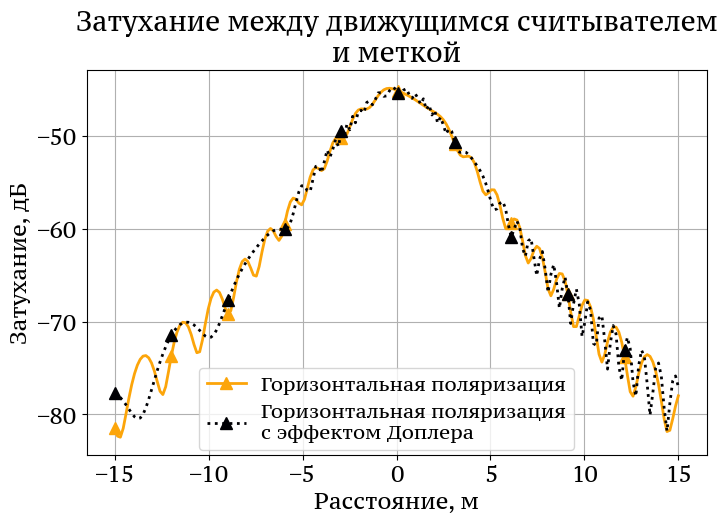

In [12]:
def plot_pathloss_with_doppler(
    image_name: str = '',
    speed: float = 60,
    t: float = 1.0,
) -> None:
    """
    Построение графика затухания с учётом эффекта Доплера.

    Args:
        image_name: имя файла (без расширения)
        speed: скорость считывателя (км/ч)
        t: время (сек)
    """
    # Получение результатов
    ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)  # Расстояние, м 
    pass_loss_hor = [get_pathloss(x, HORIZONTAL_POLARIZATION) for x in ox_axis]
    pass_loss_hor_speed = [
        get_pathloss(
            x, HORIZONTAL_POLARIZATION, v=channel.kmph2mps(speed), t=t
        ) for x in ox_axis
    ]
    
    # Оформление графиков
    fig, ax = plt.subplots(figsize=FIGSIZE, nrows=1, ncols=1)
    ax.set_title('Затухание между движущимся считывателем\nи меткой')
    ax.set_xlabel("Расстояние, м")
    ax.set_ylabel("Затухание, дБ")
    ax.plot(ox_axis, pass_loss_hor, **PARAMS_HOR)
    ax.plot(ox_axis, pass_loss_hor_speed, **PARAMS_HOR_SPEED)
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.1),
               fontsize=LEGEND_FONTSIZE)
    ax.grid()


# Вызов функции
plot_pathloss_with_doppler('', speed=60, t=1.0)

## 📶 Расчет мощностей сигналов

Рассматриваются каналы от считывателя к метке и обратно. Также учитываются различные потери внутри самих устройств.

In [13]:
def get_tag_rx(y: float, v: float, t: float, power: float = READER_TX_POWER) -> float:
    """Вычислить мощность сигнала, принятого меткой (в dBm)."""
    path_loss = get_pathloss(y, READER_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return power + path_loss + pol_loss + gain + READER_CABLE_LOSS

In [14]:
def get_tag_tx(power: float) -> float:
    """Вычислить мощность сигнала, отраженного меткой (в dBm)."""
    return power + TAG_BACKSCATTER_LOSS

In [15]:
def get_reader_rx(y: float, v: float, t: float, power: float) -> float:
    """Вычислить мощность сигнала, принятого считывателем (в dBm)."""
    path_loss = get_pathloss(y, TAG_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return power + path_loss + pol_loss + gain + READER_CABLE_LOSS

Нам потребуется определять зоны, в которых метка получает сигнал, 
выше уровня ее чувствительности. Для этого определим функцию `find_high_zones()`, 
которая будет возвращать набор интервалов, внутри которых значение функции больше
граничного значения.

In [16]:
def find_zones(
        x: Sequence[float], 
        y: Sequence[float], 
        bound: float, 
        use_upper: bool = True
) -> Sequence[Tuple[float, float]]:
    """
    Найти интервалы на X, внутри которых значение Y выше или ниже лимита.
    
    Например, если use_upper = True, то есть ищем интервалы выше лимита, то
    возвращает набор интервалов `[(x0, x1), (x2, x3), ...]`, таких, что:
    - для x[2n] <= x <= x[2n+1]: y(x) >= B
    - для x[2n+1] <= x <= x[2n+2]: y(x) <= B
    
    Размерности x и y должны совпадать.
    
    Args:
        x (sequence of float): последовательность аргументов
        y (sequence of float): последовательность значений
        bound (float): граничное значение
        use_upper (bool): если True, то ищем области, в которых значение выше
    
    Returns:
        intervals (sequence of tuples): последовательность интервалов
    """
    # Специально делаем так, чтобы изначально is_upper не совпадало с тем,
    # что будет в первой точке:
    is_upper = False
    x_left: Optional[float] = None
    intervals = []
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        
        is_start_point = False
        is_end_point = False

        if (not is_upper or (use_upper and i == 0)) and yi >= bound:

            # Если выполняется равенство, нужно проверить, возрастает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi > bound or i == len(x)-1 or y[i+1] >= bound:
                is_upper = True
                if use_upper:
                    is_start_point = True
                else:
                    is_end_point = True
                            
        elif (is_upper or (not use_upper and i == 0)) and yi <= bound:

            # Если выполняется равенство, нужно проверить, убывает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi < bound or i == len(y)-1 or y[i+1] <= bound:
                is_upper = False
                if use_upper:
                    is_end_point = True
                else:
                    is_start_point = True
        
        if is_start_point:
            x_left = xi
        if is_end_point:
            intervals.append((x_left, xi))
            x_left = None
    
    # После цикла проверяем, не надо ли закрыть интервал.
    if x_left is not None:
        intervals.append((x_left, x[-1]))
        
    return intervals

Зоны, где метка отключена: [(np.float64(-15.0), np.float64(-4.4472361809045236)), (np.float64(4.597989949748744), np.float64(15.0))]


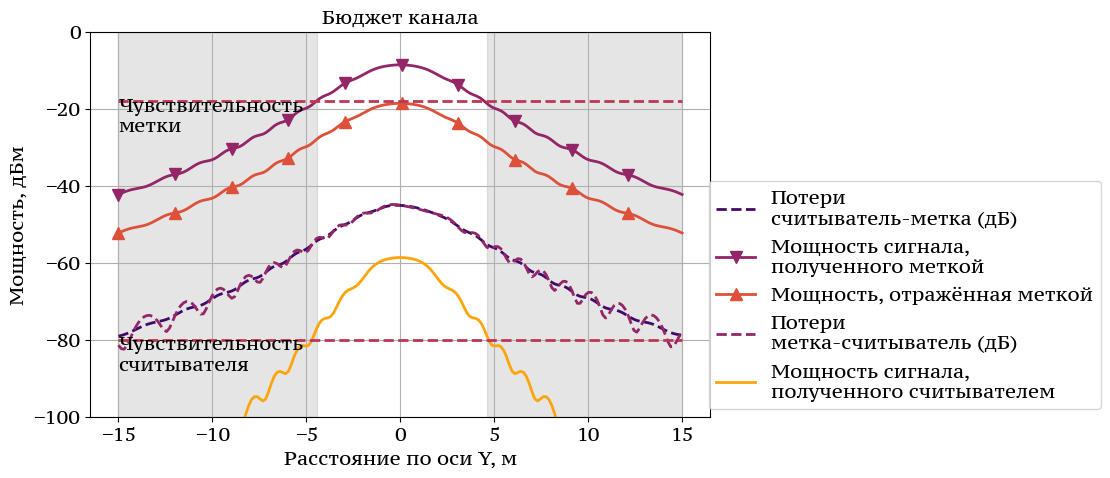

In [17]:
def plot_budget(image_name: str = '', save_fig: bool = False) -> None:
    """
    Построение графиков бюджета канала между считывателем и меткой.
    Параметры окружающей среды:
      - В системе присутстсвует отражённый (второй) луч
      - Считыватель неподвижен относительно метки
    Под ox_axis понимается ось абсцисс создаваемого графика.

    Args:
        image_name: имя файла для сохранения (без расширения)
        save_fig: сохранить ли изображение
    """
    # Получение результатов
    ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)
    reader2tag_pl = [get_pathloss(x, READER_POLARIZATION) for x in ox_axis]
    tag_accepted_power = [get_tag_rx(x, v=0, t=0) for x in ox_axis]
    tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
    tag2reader_pl = [get_pathloss(x, TAG_POLARIZATION) for x in ox_axis]
    reader_accepted_power = [get_reader_rx(x, v=0, t=0, power=tag_power) for (x, tag_power) in zip(ox_axis, tag_radiated_power)]

    # Ограничения осей
    y_max = 0
    y_min = -100

    # Оформление графиков---------------------------------------------------------
    # Получение результатов
    fig, ax = plt.subplots(figsize=FIGSIZE, nrows=1, ncols=1)
    ax.plot(ox_axis, reader2tag_pl, label='Потери\nсчитыватель-метка (дБ)',
        linewidth=LINEWIDTH, linestyle='--', color=get_color(0.2), )
    ax.plot(ox_axis, tag_accepted_power, label='Мощность сигнала,\nполученного меткой',
        linewidth=LINEWIDTH, linestyle='-', marker='v', markevery=MARKEVERY, markersize=MARKERSIZE,
        color=get_color(0.4))
    ax.plot(ox_axis, tag_radiated_power, label='Мощность, отражённая меткой',
        linewidth=LINEWIDTH, linestyle='-', marker='^', markevery=MARKEVERY, markersize=MARKERSIZE,
        color=get_color(0.6))
    ax.plot(ox_axis, tag2reader_pl, label='Потери\nметка-считыватель (дБ)',
        linewidth=LINEWIDTH, linestyle='--', color=get_color(0.4), )
    ax.plot(ox_axis, reader_accepted_power, label='Мощность сигнала,\nполученного считывателем',
        linewidth=LINEWIDTH, color=get_color(0.8))

    # Линии чувствительности метки и считывателя
    ax.hlines(y=TAG_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
          colors=get_color(0.5), linestyles='--', linewidths=2)
    ax.hlines(y=READER_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
          colors=get_color(0.5), linestyles='--', linewidths=2)

    # Области, в которых метка выключена
    tag_off_intervals = find_zones(ox_axis, tag_accepted_power, TAG_SENSITIVITY, use_upper=False)
    print(f'Зоны, где метка отключена: {tag_off_intervals}')
    for interval in tag_off_intervals:
        ax.add_patch(patches.Rectangle(xy=(interval[0], y_min), 
            width=(interval[1] - interval[0]), 
            height=(y_max - y_min),
            fill=True, color='gray', alpha=0.2))

    ax.text(x=MINIMUM_DISTANCE, y=TAG_SENSITIVITY-8, s='Чувствительность\nметки', 
            fontdict={'style': 'italic'}, fontsize=LEGEND_FONTSIZE)
    ax.text(x=MINIMUM_DISTANCE, y=READER_SENSITIVITY-8, fontsize=LEGEND_FONTSIZE,
            s='Чувствительность\nсчитывателя', 
    fontdict={'style': 'italic'})

    # Оси и легенда
    ax.set_ylim((y_min, y_max))
    ax.grid()
    ax.set_xlabel('Расстояние по оси Y, м', fontsize=LEGEND_FONTSIZE)
    ax.set_ylabel('Мощность, дБм', fontsize=LEGEND_FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=LEGEND_FONTSIZE)

    handles, labels = ax.get_legend_handles_labels()
    patch = patches.Patch(color='grey', alpha=0.5)
    handles.append(patch)
    fig.legend(bbox_to_anchor=(1.4, 0.6), fontsize=LEGEND_FONTSIZE)
    ax.set_title('Бюджет канала', fontsize=LEGEND_FONTSIZE)

# Вызов функции
plot_budget(image_name='', save_fig=False)

Эффект Доплера сильно влияет на затухание и, как следствие, на мощность 
сигналов,  принятых меткой и считывателем. 

В следующем примере посмотрим, как меняется мощность при увеличении времени, 
прошеднего со включения считывателя. Метка будет двигаться со скоростью 
`60 км/ч`.

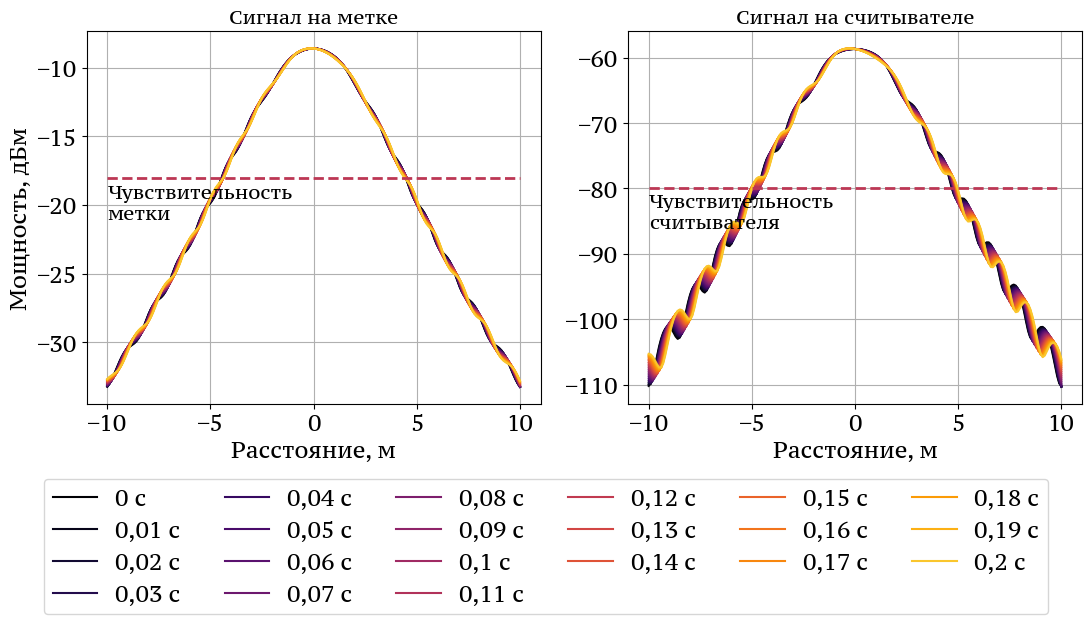

In [18]:
def plot_received_power_doppler(image_name: str = '', save_fig: bool = False) -> None:
    """
    Нарисовать графики мощностей сигналов, принятых меткой и считывателем,
    с учетом эффекта Допера.
    Переменная t в этих графиках — это время, прошедшее с начала движения считывателя.
    
    Args:
        image_name (str): имя файла без расширения
    """
    ox_axis = np.linspace(MINIMUM_DISTANCE+5, MAXIMUM_DISTANCE-5, GRID_STEP)
    times = np.linspace(0, 0.2, 21)
    v = channel.kmph2mps(DEFAULT_SPEED)
    fig, (ax0, ax1) = plt.subplots(figsize=(FIGSIZE[0]*1.4, FIGSIZE[1]), nrows=1, ncols=2)
    
    for i, t in enumerate(times):
        tag_accepted_power = [get_tag_rx(x, v, t) for x in ox_axis]
        tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
        reader_accepted_power = [get_reader_rx(x, v, t, power) for (x, power) in zip(ox_axis, tag_radiated_power)]
        
        color = get_color(i / (len(times) * 1.1))
        
        ax0.plot(ox_axis, tag_accepted_power, label=f'{t:n} с', color=color)
        ax1.plot(ox_axis, reader_accepted_power, color=color)
    
    ax0.set_ylabel('Мощность, дБм')
    for ax in (ax0, ax1):
        ax.grid()        
        ax.set_xlabel('Расстояние, м')
    
    
    ax0.set_title('Сигнал на метке', fontsize=LEGEND_FONTSIZE)
    ax1.set_title('Сигнал на считывателе', fontsize=LEGEND_FONTSIZE)

    ax0.hlines(y=TAG_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
               colors=get_color(0.5), linestyles='--', linewidths=LINEWIDTH)
    ax1.hlines(y=READER_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
               colors=get_color(0.5), linestyles='--', linewidths=LINEWIDTH)

    ax0.text(x=ox_axis[0], y=TAG_SENSITIVITY - 3, s='Чувствительность\nметки',
         fontsize=LEGEND_FONTSIZE, style='italic')

    ax1.text(x=ox_axis[0], y=READER_SENSITIVITY - 6, s='Чувствительность\nсчитывателя',
         fontsize=LEGEND_FONTSIZE, style='italic')
    
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', 
               bbox_to_anchor=(0.5, -0.28), ncol=6) 

    plt.tight_layout()

plot_received_power_doppler('', save_fig = False)

## Расчет битовой ошибки

Рассчитаем битовую ошибку и исследуем, как она зависит от параметров 
канала и эффекта Доплера.

Для расчета BER нужно знать отношение "сигнал-шум" (SNR) $\gamma$. 
Для более точных результатов лучше вместо простого SNR использовать
величину, учитывающую количество принятой энергии на бит $\acute{\gamma}$:

$$
\acute{\gamma} = \frac{m E_s}{N_0} \cos^2 \phi_s,
$$
где:

- $m$ - число символов на бит в ответах метки (1, 2, 4 или 8);
- $E_s$ - энергия на один символ;
- $N_0/2$ - спектральная плотность шума;
- $\phi_s$ - разность фазы сигнала и фазы приема.

Отношение $E_s / N_0$ можно выразить через SNR $\gamma$, длительность символа
$T_s$ и ширину полосы $B$ как $E_s / N_0 = \gamma T_s B$. Величину $\phi_s$
можно оценить как $\frac{1}{\sqrt{\gamma T_{pr} B}}$, где $T_{pr}$ - длина
преамбулы. Подставляя в форумулу, получаем:

$$
\acute{\gamma} \approx m \gamma T_s B \cos^2 \frac{1}{\sqrt{\gamma T_{pr} B}}
$$


Самая простая формула для расчета BER - канал AWGN. В нем BER рассчитывается так:

$$
P_{er} = 2 Q(\acute{\gamma}) [1 - Q(\acute{\gamma})]
$$

Эта формула слишком оптимистична, поэтому для расчета BER будем использовать формулу, 
полученную усреднением BER для канала AWGN по распределению Рэлея:

$$
BER = \frac{1}{2} - 
      \frac{1}{\sqrt{1 + \frac{2}{\acute{\gamma}}}} + 
      \frac{2}{\pi} \frac{\arctan{\sqrt{1 + \frac{2}{\acute{\gamma}}}}}{\sqrt{1 + \frac{2}{\acute{\gamma}}}}.
$$

In [19]:
def get_trcal(tari: float) -> float:
    """Вычислить TRcal от Tari."""
    rtcal = tari * RTCAL_MUL
    return rtcal * TRCAL_MUL


def get_blf(trcal: float, dr: float = DR) -> float:
    """Вычислить BLF."""
    return dr / trcal
    
    
def get_preamble(m: int, trcal: float, trext: bool = False,
                 dr: float = DR) -> float:
    """Вычислить длительность преамбулы ответа метки."""
    if m == 1:
        n_bits = 18 if trext else 6
    else:
        n_bits = 22 if trext else 10
    return n_bits / get_blf(trcal, dr)


In [20]:
NOISE = channel.to_log(
    value=(channel.from_log(READER_NOISE, dbm=True) + channel.from_log(THERMAL_NOISE, dbm=True)),
    dbm=True
)

def get_snr(rx: float, m: int, trcal: float, trext: bool = False,
            dr: float = DR) -> float:
    """Вычислить SNR на бит с поправкой на синхронизацию."""
    snr = channel.snr(power=rx, noise=NOISE)
    preamble = get_preamble(m, trcal, trext, dr)
    return channel.snr_full(
        snr=snr, 
        miller=m, 
        symbol=(1 / get_blf(trcal, dr)),
        preamble=preamble
    )


Рассчитаем BER для разных Tari, M и DR.

Чтобы немного упростить вывод, не будем рассматривать все возможные комбинации 
`Tari`, `M`, `DR`, а выделим шесть разных наборов:

- `Tari = 6.25, M = 1, DR = 64/3, TRext = False` (самый быстрый)
- `Tari = 6.25, M = 4, DR = 64/3, TRext = False`
- `Tari = 12.5, M = 4, DR = 64/3, TRext = False`
- `Tari = 12.5, M = 4, DR = 8, TRext = False`
- `Tari = 25.0, M = 4, DR = 8, TRext = True`
- `Tari = 25.0, M = 8, DR = 8, TRext = True` (самый медленный)

In [21]:
SERIES = [
    [6.25, epc.TagEncoding.FM0, epc.DivideRatio.DR_643],
    [6.25, epc.TagEncoding.FM0, epc.DivideRatio.DR_8],
    [6.25, epc.TagEncoding.M4, epc.DivideRatio.DR_643],
    [12.5, epc.TagEncoding.M4, epc.DivideRatio.DR_643],
    [12.5, epc.TagEncoding.M4, epc.DivideRatio.DR_8],
    [25.0, epc.TagEncoding.M4, epc.DivideRatio.DR_8],
    [25.0, epc.TagEncoding.M8, epc.DivideRatio.DR_8]
]
SERIES_SIZE = len(SERIES)
SERIES_MARKERS = ["o", "v", "^", "X", "D", "*", "s"]
SERIES_COLORS = [get_color(i / SERIES_SIZE * 0.8) for i in range(SERIES_SIZE)]

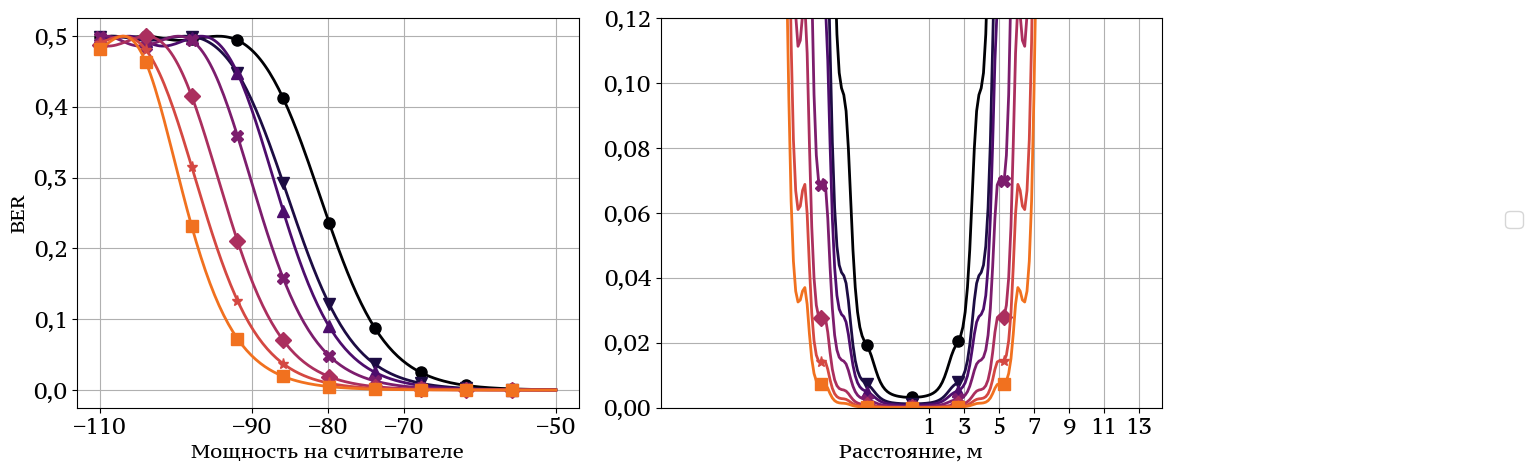

In [26]:
def plot_ber(image_name: str = '', save_fig: bool = False) -> None:
    """
    Нарисовать графики зависимостей BER от SNR и от расстояния между 
    считывателем и меткой.
    
    Args:
        image_name (str): имя файла без расширения
    """
    fig, axes = plt.subplots(figsize=(FIGSIZE[0]+4, FIGSIZE[1]), nrows=1, ncols=2)
    ax0, ax1 = axes

    ox_axis = np.linspace(MINIMUM_DISTANCE+2, MAXIMUM_DISTANCE-2, GRID_STEP)
    basic_rx = np.linspace(-110, -50, GRID_STEP)

    tag_accepted_power = [get_tag_rx(x, v=0, t=0) for x in ox_axis]
    tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
    reader_accepted_power = [get_reader_rx(x, v=0, t=0, power=tag_power) for (x, tag_power) in zip(ox_axis, tag_radiated_power)]
    
    for i, (tari_us, m, dr) in enumerate(SERIES):
        tari = tari_us * 1e-6
        trcal = get_trcal(tari)
        m_tag_value = m.value[1] # пример m.value: ('10', 4, 'M4')
        
        snr_on_reader = [get_snr(power, m_tag_value, trcal, False, dr.eval()) for power in reader_accepted_power]
        ber_on_reader = [channel.ber(snr) for snr in snr_on_reader]
        
        basic_snr = [get_snr(power, m_tag_value, trcal, False, dr.eval()) for power in basic_rx]
        basic_ber = [channel.ber(snr) for snr in basic_snr]
        
        props = {
            'linewidth': LINEWIDTH, 
            'marker': SERIES_MARKERS[i], 
            'color': SERIES_COLORS[i],
            'markevery': MARKEVERY, 
            'markersize': MARKERSIZE,
            # 'label': (f"Tari = {tari_us:n} мкс,\n"
            #           f"{m.name}, DR = {str_dr(dr)}")
        }
        ax0.plot(basic_rx, basic_ber, **props)
        ax1.plot(ox_axis, ber_on_reader, **props)        
    
    for ax in axes:
        ax.grid()
    
    ax0.set_ylabel('BER', fontsize=LEGEND_FONTSIZE)
    ax0.set_xlabel('Мощность на считывателе', fontsize=LEGEND_FONTSIZE)
    ax1.set_xlabel('Расстояние, м', fontsize=LEGEND_FONTSIZE)
    ax1.set_ylim((0, 0.12))
    ax0.set_xticks((-110, -90, -80, -70, -50))
    ax1.set_xticks((1, 3, 5, 7, 9, 11, 13))
    
    fig.legend(*ax0.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.29, 0.533), ncol=1)

    plt.tight_layout()

plot_ber('', save_fig = False)

Теперь рассчитаем BER с учетом эффекта Доплера.

TypeError: unsupported operand type(s) for /: 'DivideRatio' and 'float'

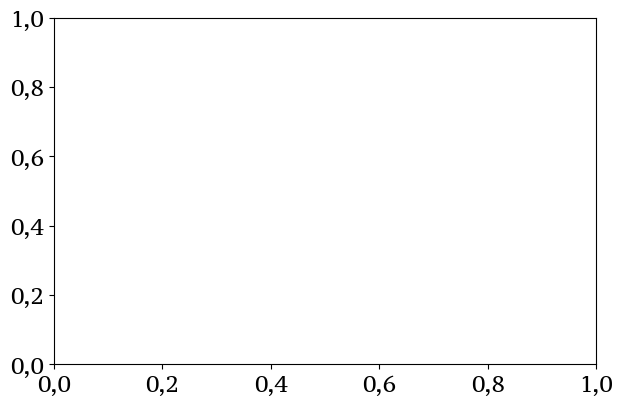

In [23]:
def plot_ber_doppler(
        image_name: str = "", 
        m: int = 2, 
        tari_us: float = 12.5
) -> None:
    """
    Нарисовать график BER от расстояния по земле с учетом эффекта Доплера.
    
    Args:
        image_name (str): имя файла без расширения
        m (int): число символов на бит в ответе метки (1, 2, 4, 8)
        tari_us (float): величина Tari в микросекундах (по-умолчанию, 12.5)
    """
    ox = np.linspace(1, 15, 150)
    ts = np.linspace(0, 0.2, 21)
    v = channel.kmph2mps(60)
    fig, ax = plt.subplots(figsize=(7, 4.5), nrows=1, ncols=1)
    
    tari = tari_us * 1e-6
    trcal = get_trcal(tari)
    
    for i, t in enumerate(ts):
        tag_accepted_power = [get_tag_rx(x, v, t) for x in ox]
        tag_tx = [get_tag_tx(rx) for rx in tag_accepted_power]
        reader_accepted_power = [get_reader_rx(x, v, t, tx) for (x, tx) in zip(ox, tag_tx)]
        
        rdr_snr = [get_snr(rx, m, trcal) for rx in reader_accepted_power]
        ber = [get_ber(snr) for snr in rdr_snr]
        
        color = get_color(i / (len(ts) * 1.1))
        ax.plot(ox, ber, label=f"{t:n} с", color=color)
    
    ax.grid()
    ax.set_ylabel("BER")
    ax.set_xlabel("Расстояние, м")
    ax.set_ylim((0, 0.2))
    
    # ax0.set_ylim((-20, -13))
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.46, 0.51), ncol=2) 
        
    plt.tight_layout()
    savefig(image_name)

plot_ber_doppler("ch2_ber_doppler")